In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 3b
commitnumber = d5931a1
conc = 0.0004
dv = 0.001
klin = 0
molecule = co2
ng_adju = [0, 0]
ng_refs = [5, 2]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250)]
tsfc = 257
vmax = 720
vmin = 620
w_diffuse = [(1.66, 1.66, 1.66, 1.66, 1.66), (1.66, 1.66)]
wgt = [(0.7, 0.8, 0.8, 0.7, 0.5), (0.6, 0)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

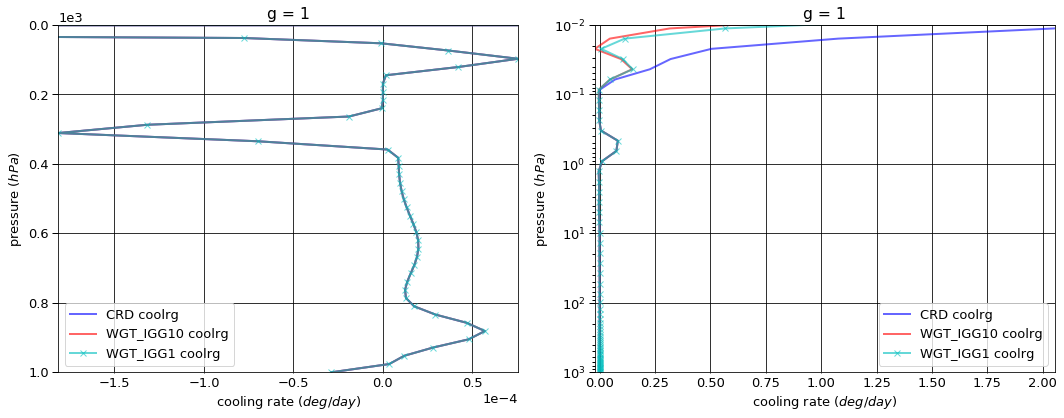

# Figure: cooling rate g-group 2

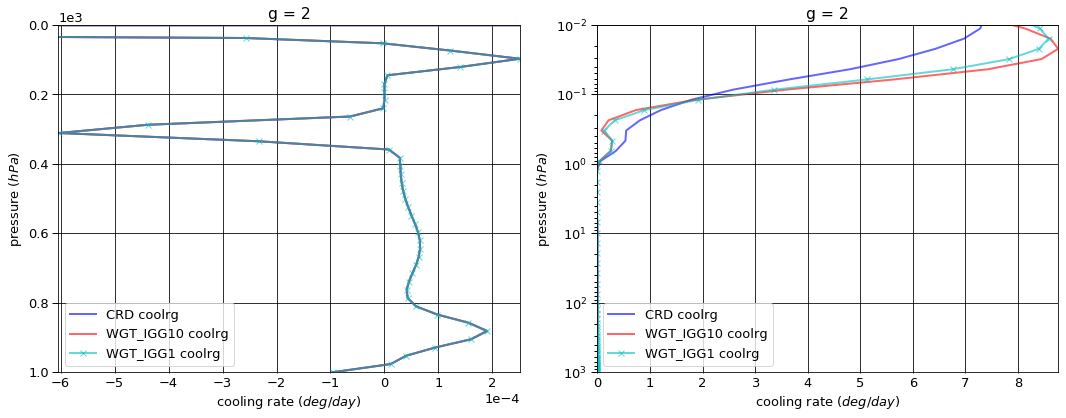

# Figure: cooling rate g-group 3

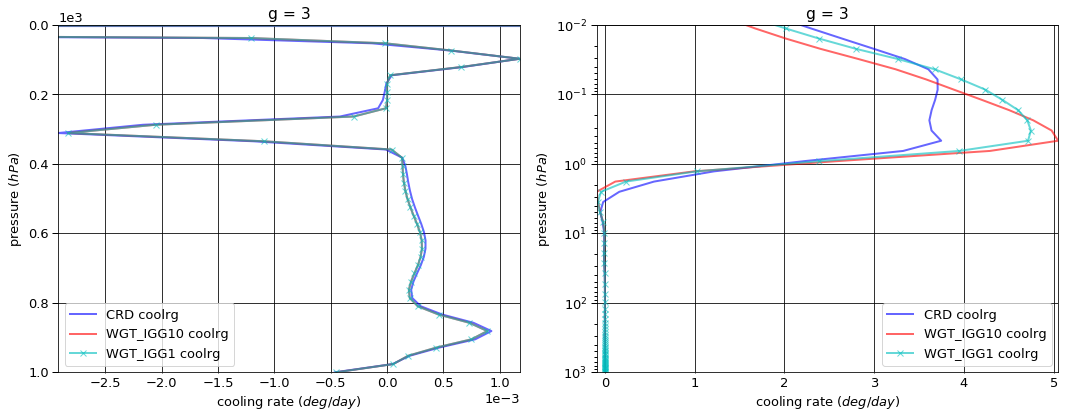

# Figure: cooling rate g-group 4

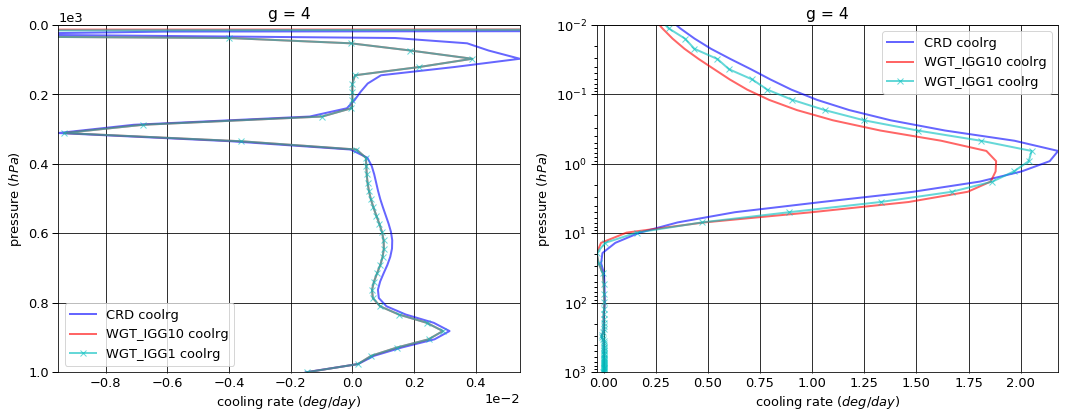

# Figure: cooling rate g-group 5

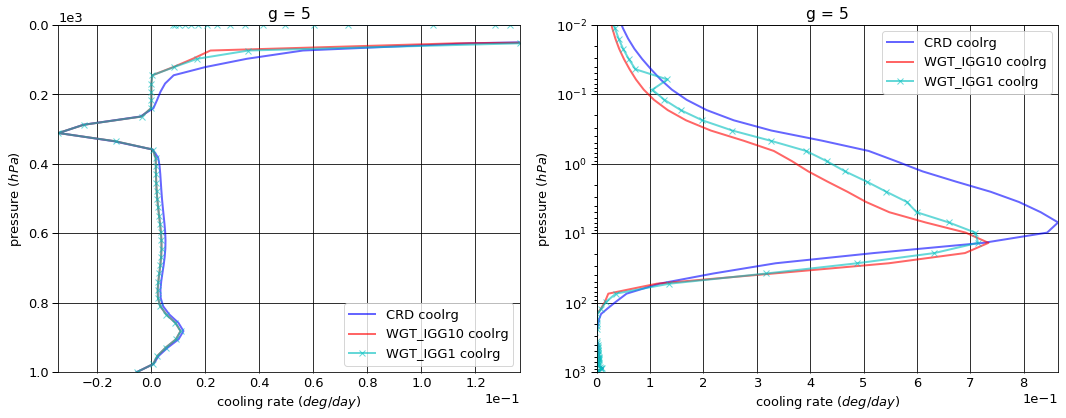

# Figure: cooling rate g-group 6

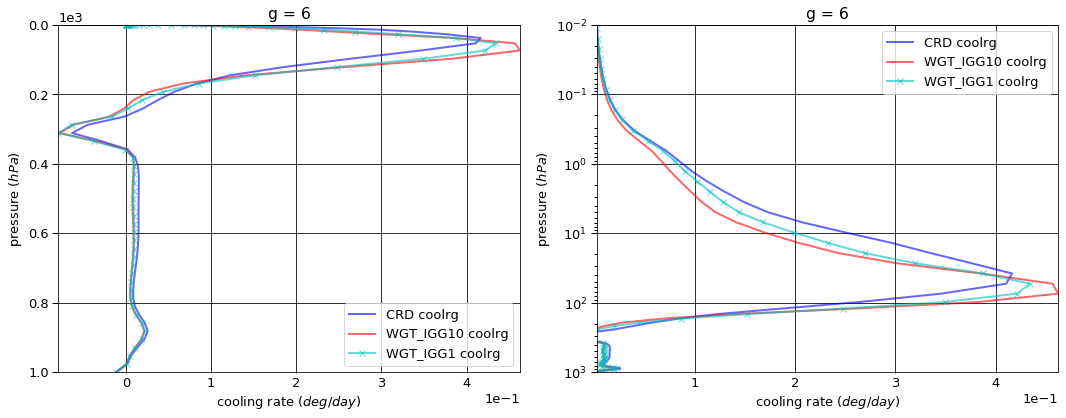

# Figure: cooling rate g-group 7

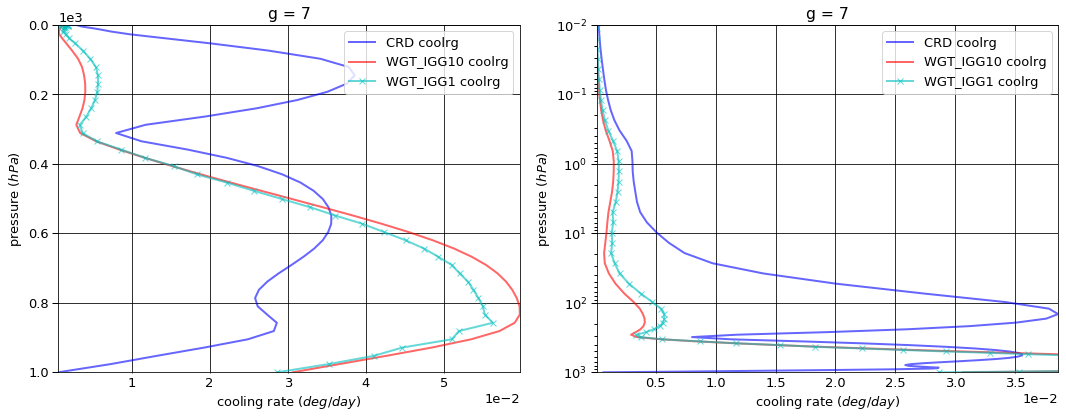

# Figure: cooling rate g-group total

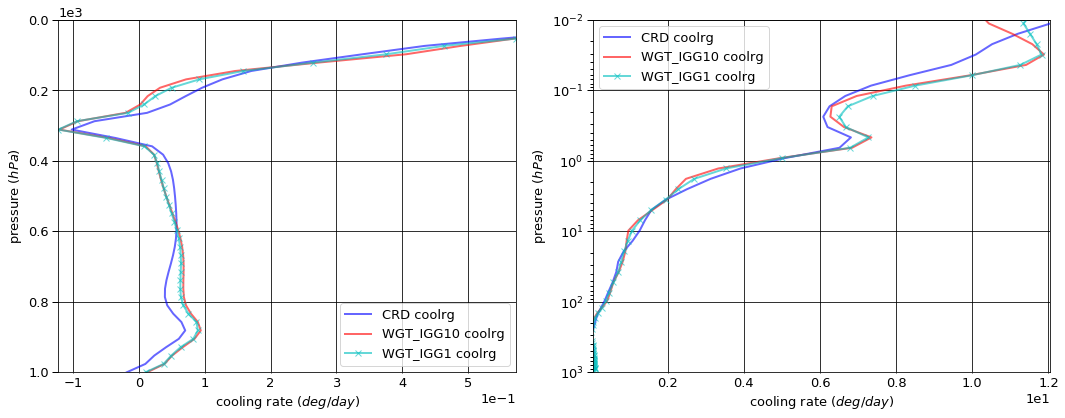

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.017989   0.000000 -0.017989
  1013.0   76     -0.034720   0.034906  0.000186
2 0.0      1      -0.095166   0.000000 -0.095166
  1013.0   76     -0.115359   0.115983  0.000623
3 0.0      1      -0.476343   0.000000 -0.476343
  1013.0   76     -0.541847   0.544869  0.003022
4 0.0      1      -1.118182   0.000000 -1.118182
  1013.0   76     -1.789812   1.799709  0.009897
5 0.0      1      -3.232115   0.000000 -3.232115
  1013.0   76     -6.592070   6.627533  0.035463
6 0.0      1      -6.203177   0.000000 -6.203177
  1013.0   76    -12.790834  12.867346  0.076512
7 0.0      1      -3.146809   0.000000 -3.146809
  1013.0   76     -5.172576   5.124831 -0.047746


WGT_IGG10


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.016849   0.000000 -0.016849
  1013.0   76     -0.034724   0.034909  0.000186
2 0.0      1      -0.091501   0.000000 -0.091501
  1013.0   76     -0.115389   0.116006  0.000618
3 0.0      1      -0.503780   0.000000 -0.503780
  1013.0   76     -0.541988   0.544889  0.002901
4 0.0      1      -1.130385   0.000000 -1.130385
  1013.0   76     -1.790269   1.799850  0.009581
5 0.0      1      -3.128513   0.000000 -3.128513
  1013.0   76     -6.593518   6.628805  0.035287
6 0.0      1      -6.145848   0.000000 -6.145848
  1013.0   76    -12.791405  12.861320  0.069914
7 0.0      1      -4.135605   0.000000 -4.135605
  1013.0   76     -5.169926   4.500953 -0.668972


WGT_IGG1


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.016982   0.000000 -0.016982
  1013.0   76     -0.034724   0.034909  0.000186
2 0.0      1      -0.091478   0.000000 -0.091478
  1013.0   76     -0.115389   0.116006  0.000618
3 0.0      1      -0.498120   0.000000 -0.498120
  1013.0   76     -0.541988   0.544889  0.002901
4 0.0      1      -1.134433   0.000000 -1.134433
  1013.0   76     -1.790269   1.799850  0.009581
5 0.0      1      -3.147426   0.000000 -3.147426
  1013.0   76     -6.593518   6.628805  0.035287
6 0.0      1      -6.149674   0.000000 -6.149674
  1013.0   76    -12.791405  12.862979  0.071574
7 0.0      1      -4.123958   0.000000 -4.123958
  1013.0   76     -5.169926   4.342637 -0.827289


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1      0.001139  0.000000  1.139050e-03
  1013.0   76    -0.000004  0.000004  2.117100e-07
2 0.0      1      0.003665  0.000000  3.665332e-03
  1013.0   76    -0.000029  0.000024 -5.543240e-06
3 0.0      1     -0.027437  0.000000 -2.743732e-02
  1013.0   76    -0.000142  0.000020 -1.214427e-04
4 0.0      1     -0.012203  0.000000 -1.220350e-02
  1013.0   76    -0.000457  0.000141 -3.160475e-04
5 0.0      1      0.103602  0.000000  1.036023e-01
  1013.0   76    -0.001448  0.001272 -1.757190e-04
6 0.0      1      0.057330  0.000000  5.732970e-02
  1013.0   76    -0.000571 -0.006026 -6.597437e-03
7 0.0      1     -0.988796  0.000000 -9.887959e-01
  1013.0   76     0.002650 -0.623877 -6.212268e-01


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1      0.001007  0.000000  1.006880e-03
  1013.0   76    -0.000004  0.000004  2.117100e-07
2 0.0      1      0.003688  0.000000  3.687788e-03
  1013.0   76    -0.000029  0.000024 -5.543240e-06
3 0.0      1     -0.021777  0.000000 -2.177735e-02
  1013.0   76    -0.000142  0.000020 -1.214427e-04
4 0.0      1     -0.016251  0.000000 -1.625130e-02
  1013.0   76    -0.000457  0.000141 -3.160475e-04
5 0.0      1      0.084690  0.000000  8.468990e-02
  1013.0   76    -0.001448  0.001272 -1.757200e-04
6 0.0      1      0.053503  0.000000  5.350290e-02
  1013.0   76    -0.000571 -0.004367 -4.938113e-03
7 0.0      1     -0.977150  0.000000 -9.771496e-01
  1013.0   76     0.002650 -0.782194 -7.795435e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer           
1 0.000312    1      63.651617
  1001.112500 75     -0.000029
2 0.000312    1       3.043463
  1001.112500 75     -0.000097
3 0.000312    1       0.050917
  1001.112500 75     -0.000464
4 0.000312    1       0.052453
  1001.112500 75     -0.001519
5 0.000312    1       0.010665
  1001.112500 75     -0.005559
6 0.000312    1       0.000371
  1001.112500 75     -0.011762
7 0.000312    1       0.000035
  1001.112500 75      0.000624


WGT_IGG10


coolrg
g pressure    layer           
1 0.000312    1      64.636041
  1001.112500 75     -0.000029
2 0.000312    1       1.095257
  1001.112500 75     -0.000096
3 0.000312    1      -0.145258
  1001.112500 75     -0.000450
4 0.000312    1       0.057905
  1001.112500 75     -0.001486
5 0.000312    1       0.006906
  1001.112500 75     -0.005471
6 0.000312    1       0.000304
  1001.112500 75     -0.010986
7 0.000312    1       0.000004
  1001.112500 75      0.030655


WGT_IGG1


coolrg
g pressure    layer           
1 0.000312    1      66.920385
  1001.112500 75     -0.000029
2 0.000312    1       1.907652
  1001.112500 75     -0.000096
3 0.000312    1      -0.176968
  1001.112500 75     -0.000450
4 0.000312    1       0.053424
  1001.112500 75     -0.001486
5 0.000312    1       0.007844
  1001.112500 75     -0.005471
6 0.000312    1       0.000366
  1001.112500 75     -0.011379
7 0.000312    1       0.000008
  1001.112500 75      0.028660


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      9.844240e-01
  1001.112500 75    -3.417300e-08
2 0.000312    1     -1.948206e+00
  1001.112500 75     1.017358e-06
3 0.000312    1     -1.961750e-01
  1001.112500 75     1.445249e-05
4 0.000312    1      5.452387e-03
  1001.112500 75     3.340850e-05
5 0.000312    1     -3.759543e-03
  1001.112500 75     8.714740e-05
6 0.000312    1     -6.718028e-05
  1001.112500 75     7.759090e-04
7 0.000312    1     -3.158044e-05
  1001.112500 75     3.003150e-02


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.268768e+00
  1001.112500 75    -3.417300e-08
2 0.000312    1     -1.135811e+00
  1001.112500 75     1.017358e-06
3 0.000312    1     -2.278846e-01
  1001.112500 75     1.445249e-05
4 0.000312    1      9.709110e-04
  1001.112500 75     3.340850e-05
5 0.000312    1     -2.821524e-03
  1001.112500 75     8.714750e-05
6 0.000312    1     -5.602910e-06
  1001.112500 75     3.824530e-04
7 0.000312    1     -2.712506e-05
  1001.112500 75     2.803617e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-14.289781,0.000000,-14.289781
1013.0,76,-27.037219,27.115176,0.077957



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-15.152481,0.000000,-15.152481
1013.0,76,-27.037219,26.486733,-0.550486



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-15.162071,0.000000,-15.162071
1013.0,76,-27.037219,26.330076,-0.707144



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.627003e-01,0.000000,-0.862700
1013.0,76,-1.610000e-07,-0.628442,-0.628443



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.722908e-01,0.0000,-0.872291
1013.0,76,-1.610000e-07,-0.7851,-0.785100


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,66.809521
1001.112500,75,-0.018805



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,65.651158
1001.112500,75,0.012138



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,68.71271
1001.112500,75,0.00975



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-1.158363
1001.112500,75,0.030943



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,1.903190
1001.112500,75,0.028555


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.00128,0.001284
2,0.00425,0.004268
3,0.01996,0.020046
4,0.06595,0.066215
5,0.24303,0.243868
6,0.47273,0.473104
7,0.19280,0.191215


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.306538e-17
2,6.987267e-19
3,3.736738e-20
4,1.998379e-21
5,1.068718e-22
6,5.714218e-23
7,3.056582e-24


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.306538e-17,NaN,0.00128,0.001284,0.00128,0.001284,1.0
2,6.987267e-19,0.053479,0.00425,0.004268,0.00553,0.005552,1.0
3,3.736738e-20,0.053479,0.01996,0.020046,0.02549,0.025598,1.0
4,1.998379e-21,0.053479,0.06595,0.066215,0.09144,0.091813,1.0
5,1.068718e-22,0.053479,0.24303,0.243868,0.33447,0.335681,1.0
6,5.714218e-23,0.534680,0.47273,0.473104,0.80720,0.808785,10.0
7,3.056582e-24,0.053491,0.19280,0.191215,1.00000,1.000000,10.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
